### **CityScapes Dataset**

Team Members:

1. **Harshit Shrimali**
2. **Pooja Kangokar Pranesh**
3. **Vishnu Priya Thanda**

#### 1.  Context

Cityscapes dataset contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the Pix2Pix paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image.


#### 2. DataSet Link:

  * Dataset-Home Page - https://www.cityscapes-dataset.com/

For our project, we will be using [cityscapes dataset](https://www.cityscapes-dataset.com/) which consists of diverse urban street scenes across 50 different cities at varying times of the year with dense pixel level annotations that allow us to build a semantic segmentation model. We have 5000 images at 1024x2048 resolution pre-split into train, validation, and test set and labeled annotations that span across 30+ classes and 8 categories that are commonly encountered during driving scene perception.

#### ***Goal***

*Semantic Segmentation using CityScape Dataset*


#### ***What is Semantic Segmentation?***

Semantic segmentation is a deep learning algorithm that associates a label or category with every pixel in an image.

#### ***Our Applications:***

1. Real-world urban scene understanding

2. Autonomous Driving

3. Robotic navigation

### **1. Load Dataset**

In [ ]:
!pip install -qq cityscapesscripts
!pip install -qq pytorch_lightning
!pip install -qq segmentation_models_pytorch

In [ ]:
# All required imports
from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'
COLAB_DIR = '/content/'

from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive
import glob
import os
import cv2

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.cluster import KMeans

import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp

from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# download from cityscape website
from cityscapesscripts.download import downloader

# provide login details for this webseit to download the dataset https://www.cityscapes-dataset.com/
session = downloader.login()
downloader.get_available_packages(session=session)

# data for semantic segmentation task
print('Downloading gtFine and leftImg8bit packages ...\n')
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path=COLAB_DIR)

Cityscapes username or email address: vthanda1@umbc.edu
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y



#### Unzip datatset 

In [ ]:
# Unzip the loaded files
!unzip -q gtFine_trainvaltest.zip -d gtFine
!unzip -q leftImg8bit_trainvaltest.zip -d leftImg

#### Handle Sub Directories

In [ ]:
#Annotation and Image File Path
GT_ANN_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_MSK_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

'''Find child directories and collapse them back to main dir
   if any chid directory is present move it back to parent, so it will make easier to train all images;
   withouth needing to loop each child directories.
'''
# check the child directories in annoation folder
for p in listdir(GT_ANN_DIR):
    parent_dir = GT_ANN_DIR + p
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

# check the child directories in image folder
for p in listdir(IMG_MSK_DIR):
    parent_dir = IMG_MSK_DIR + p
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

#### Dimension Reductionality

In [ ]:
# process annotation and archive images in smaller size for quicker processing
IMG_SHAPE = 299, 299

# resize image function helps to reduce the size of the image
def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

# concat all the paths of gt annotation folder
gt_train_paths = [GT_ANN_DIR+'train/' + path for path in listdir(GT_ANN_DIR+'train/')]
gt_test_paths = [GT_ANN_DIR+'test/' + path for path in listdir(GT_ANN_DIR+'test/')]
gt_val_paths = [GT_ANN_DIR+'val/' + path for path in listdir(GT_ANN_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

# concat all the paths of original image folder
im_train_paths = [IMG_MSK_DIR+'train/' + path for path in listdir(IMG_MSK_DIR+'train/')]
im_test_paths = [IMG_MSK_DIR+'test/' + path for path in listdir(IMG_MSK_DIR+'test/')]
im_val_paths = [IMG_MSK_DIR+'val/' + path for path in listdir(IMG_MSK_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

# call resize image defination
for img in gt_paths + im_paths:
    resize_image(img)

# arhive the resized images
make_archive('gtFine', 'zip', GT_ANN_DIR)
make_archive('leftImg', 'zip', IMG_MSK_DIR)

'/content/leftImg.zip'

#### Helper function to download any missing data

In [ ]:
'''
  The following code will helps us to avoid resizeing of the images everytime for our run.
'''
def download_if_missing(url, target, extract=True):
    if os.path.exists(target):
        return target
    return tf.keras.utils.get_file(target, origin=url, extract=extract)

gt_url_file = 'https://storage.googleapis.com/UF51933/gtFine.zip'
im_url_file = 'https://storage.googleapis.com/UF51933/leftImg.zip'

gt_file, gt_dir = join(COLAB_DIR + 'gtFine.zip'), join(COLAB_DIR + 'gtFine/')
im_file, im_dir = join(COLAB_DIR + 'leftImg.zip'), join(COLAB_DIR + 'leftImg/')

download_if_missing(gt_url_file, gt_file, extract=False)
download_if_missing(im_url_file, im_file, extract=False)

!unzip -q $gt_file -d $gt_dir
!unzip -q $im_file -d $im_dir

#### Create tenserflow objects

In [ ]:
# normalizing image pixels to 299, 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Directories for annotation and orginal images
GT_ANN_DIR = COLAB_DIR + 'gtFine/'
IMG_MSK_DIR = COLAB_DIR + 'leftImg/'

# load the images
def load_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [299, 299]) # pass image size
    img /= 255.0
    return img

# get the image paths
def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects of annotations
an_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_ANN_DIR+'train/'))
an_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_ANN_DIR+'val/'))
an_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_ANN_DIR+'test/'))
an_train_ds = an_train_ds.map(load_preprocess_image)
an_val_ds = an_val_ds.map(load_preprocess_image)
an_test_ds = an_test_ds.map(load_preprocess_image)

# create tf.Dataset objects of images
im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_MSK_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_MSK_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_MSK_DIR+'test/'))
im_train_ds = im_train_ds.map(load_preprocess_image)
im_val_ds = im_val_ds.map(load_preprocess_image)
im_test_ds = im_test_ds.map(load_preprocess_image)

### **2. Data Exploration**

In [ ]:
'''
  The following function is used to plot the original and masked images in our project
  If Prediction is None we will plot 2 Imges - Original and Mask
  If Prediction is Not None will plot 3 Images - Original, Mask and Predicted Image
'''
def plot_image(image, annotation, prediction):
    if prediction is not None:
        fig, axes = plt.subplots(1, 3, figsize=(11, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(11, 8))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')

    axes[1].imshow(annotation)
    axes[1].set_title('Masked Image')
    
    if prediction is not None:
        axes[2].imshow(prediction)
        axes[2].set_title('Predicted Image')

#### Image Plot

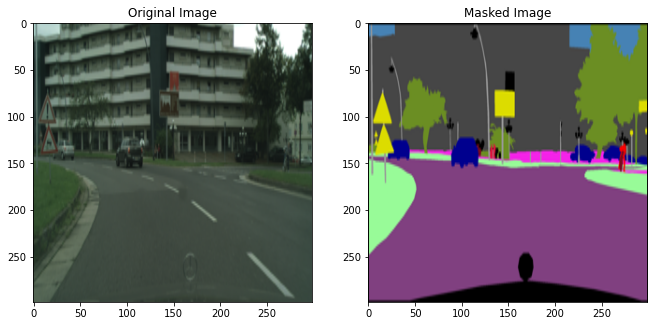

In [ ]:
# plotting of original and mask image for understanding the data structure.

for image, annot in list(zip(im_train_ds.take(1), an_train_ds.take(1))):
    plot_image(image, annot, None)

#### Explanation

* Dataset contains images that is combined with mask; i.e image = original_imgae+corresponding_mask 
* We have to work on assigning classes to mask image.

### **3. Models**

#### PSP-Net

**Pyramid Scene Parsing Network** (PSP Net) is one of the most well-recognized image segmentation algorithms as it won ImageNet Scene Parsing Challenge 2016 and its paper is highly cited by the computer vision community. It is another semantic segmentation model along with the Unet that has been implemented into the arcgis.learn module which can be trained to classify pixels in a raster. It is an improvement over Fully Convolutional Network (FCN) based segmentation.

The PSPNet architechture takes into account the global context of the image to predict the local level predictions hence gives better performance. The model was needed because FCN based pixel classifiers were not able to capture the context of the whole image.

Example: 

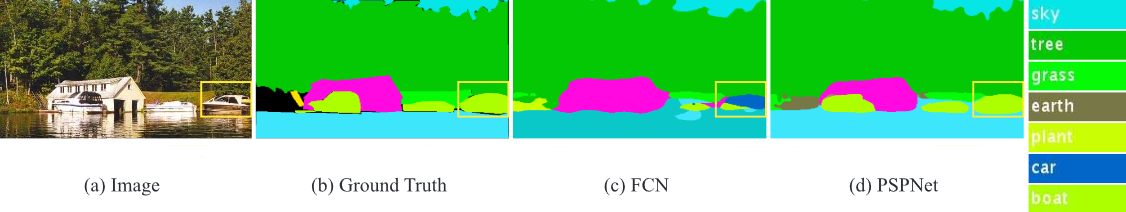

Figure 1. Image comparing FCN and PSPNet [1]

For Exaplanation of above picture: The boat inside the yellow bounding box in (a) is classified as a "car" by a FCN based classifier (c). It is because of its shape and appearance. But it is uncommon to see a car in river. If the model could gain information from the context, for example in our case water around the object, it will be able to correctly classify it. The PSPNet model (d) is able to capture the context of the whole image to classify the object as a boat (Green).

#### PSPNet Architecture

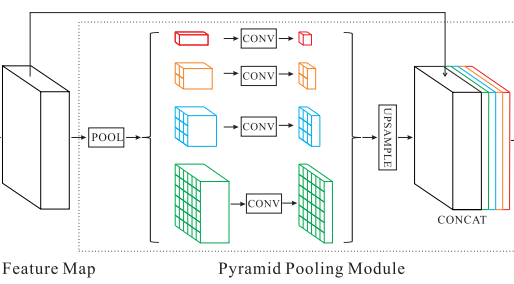

References : https://developers.arcgis.com/python/guide/how-pspnet-works/

In [ ]:
IMG_SIZE = 299

def conv_block(X,filters,block):
    '''
       Resiudal block with dilated convolutions and later
       add skip connections at last after completing convolutions
    '''

    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X

    # block a
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
               padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    ''' Fuction will help to extract features from input image '''
    
    # block_1
    base = conv_block(input_layer,[16,16,32],'1')
    # block_2
    base = conv_block(base,[16,16,32],'2')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,32))(red)
    red = Conv2D(filters=32,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=128,interpolation='bilinear',name='red_upsampling')(red)
    red = tf.image.resize(red, [299, 299])
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=32,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    yellow = tf.image.resize(yellow, [299, 299])
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=32,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    blue = tf.image.resize(blue, [299, 299])
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=32,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    green = tf.image.resize(green, [299, 299])
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    return X

In [ ]:
input_shape = list(im_train_ds.take(1))[0].shape
input_layer = tf.keras.Input(shape=input_shape, name='input')
output_layer = last_conv_module(input_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block_1_a (Conv2D)             (None, 299, 299, 16  64          ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block_1_batch_norm_a (BatchNor  (None, 299, 299, 16  64         ['block_1_a[0][0]']              
 malization)                    )                                                             

In [ ]:
# cache all tensors for quicker run
train_ds = tf.data.Dataset.zip((im_train_ds, an_train_ds))
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.zip((im_val_ds, an_val_ds))
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.zip((im_test_ds, an_test_ds))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Save the trained model to this path
checkpoint_path = drive_root+'pspnet/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# model run
model.compile(optimizer='adam', loss='mse', metrics='accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[cp_callback, es_callback])
model.save(drive_root + 'pspnet_trained.h5')

loss, acc = model.evaluate(test_ds)
print('Test Data Accuracy: ', acc)

Epoch 1/3
93/93 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.7025
Epoch 1: saving model to /gdrive/My Drive/pspnet/cp.ckpt
93/93 [==============================] - 109s 1s/step - loss: 0.0632 - accuracy: 0.7025 - val_loss: 0.0877 - val_accuracy: 0.6869
Epoch 2/3
93/93 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.6960
Epoch 2: saving model to /gdrive/My Drive/pspnet/cp.ckpt
93/93 [==============================] - 91s 976ms/step - loss: 0.0520 - accuracy: 0.6960 - val_loss: 0.0841 - val_accuracy: 0.6962
Epoch 3/3
93/93 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.6672
Epoch 3: saving model to /gdrive/My Drive/pspnet/cp.ckpt
48/48 [==============================] - 14s 294ms/step - loss: 0.2417 - accuracy: 0.9623
Test Data Accuracy:  0.9622767567634583


93/93 [==============================] - 24s 263ms/step


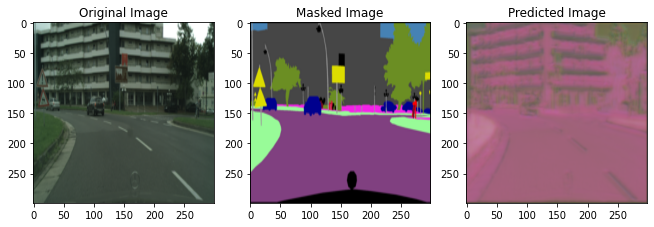

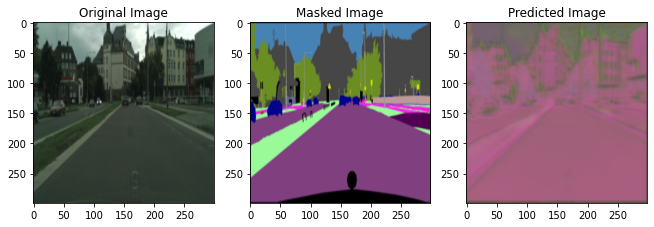

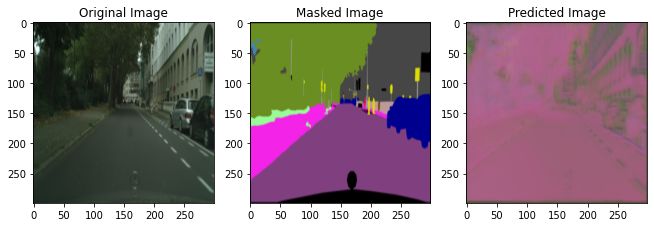

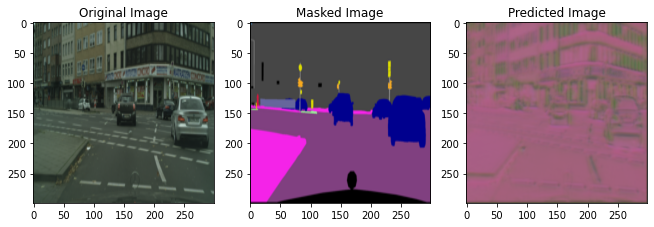

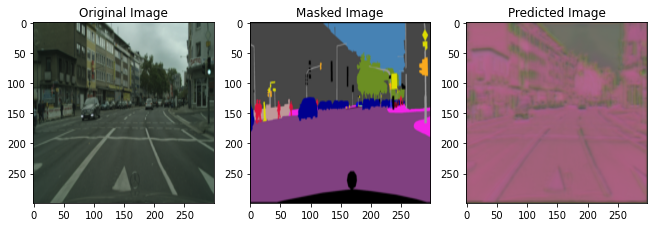

In [ ]:
# prediction
pred_test_ds = model.predict(train_ds)

for img, gt, pred in list(zip(im_train_ds.take(5), an_train_ds.take(5), pred_test_ds)):
    plot_image(img, gt, pred)

### **4. Prediction On Real Data using PSP-NET**

In [ ]:
import os

checkpoint_path = drive_root+'pspnet/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model.load_weights(checkpoint_path)

In [ ]:
import cv2
# vidcap = cv2.VideoCapture(drive_root+'Cityscape_Arbutus.mp4') # upload file
vidcap = cv2.VideoCapture(drive_root+'city.mp4') # upload file
success, image = vidcap.read()
count = 0

# video to frames generation
while success:
    cv2.imwrite('orig_frame_%.3d.jpg' % count, image)  # save frame as JPEG file
    success, image = vidcap.read()
    count += 1

frames = [img for img in get_image_paths(COLAB_DIR) if img.endswith('.jpg')]

#print(cv2.imread(frames[0]))

def convert_to_video(image_paths, video_name):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, 100, (width,height))
    for image in image_paths:
        video.write(cv2.imread(image))
    cv2.destroyAllWindows()
    video.release()
  
# model predictions on generated frames
eval_ds = tf.data.Dataset.from_tensor_slices(frames)
eval_ds = eval_ds.map(load_preprocess_image)
eval_ds = eval_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
convert_to_video(frames, 'original_video.avi')

pred_frames = model.predict(eval_ds)
count = 0
for image in pred_frames:
    plt.imsave('pred_frame_%.3d.png' % count, image)
    count += 1
# converting predictions to a video back
frames = [img for img in get_image_paths(COLAB_DIR) if img.endswith('.png')]
convert_to_video(frames, 'predicted_video.avi')

12/12 [==============================] - 4s 315ms/step


In [ ]:
!ffmpeg -i original_video.avi input.mp4
!ffmpeg -i predicted_video.avi out.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('input.mp4','rb').read()
indata_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out.mp4','rb').read()
outdata_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [ ]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % indata_url)

In [ ]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % outdata_url)

### **5. U-Net using Pytorch**

**U-Net:** 
- This is a special kind of CNN, which uses **concatenate layers** to feed data from previous layers to the layers close to the output. 
- The network has a **double-funnel shape** to ensure that no data is lost
- The network has 24 million trainable parameters.

In [ ]:
# Read cityscape dataset using Cityscapes torch dataloader
dataset = Cityscapes('/content/', split='train', mode='fine',
                      target_type='semantic')

In [ ]:
'''
    Choose the required label/classes from the dataset
    Ref: https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
'''
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)

# picking the colors from labels.py corresponding to each class_names
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

def encode_segmap(mask):
    '''
        Remove unwanted classes and recitify the labels of wanted classes
    '''
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    '''
        Convert gray scale to color
    '''
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [ ]:
# Apply transformations on the dataset
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

torch.Size([3, 256, 512]) torch.Size([256, 512])


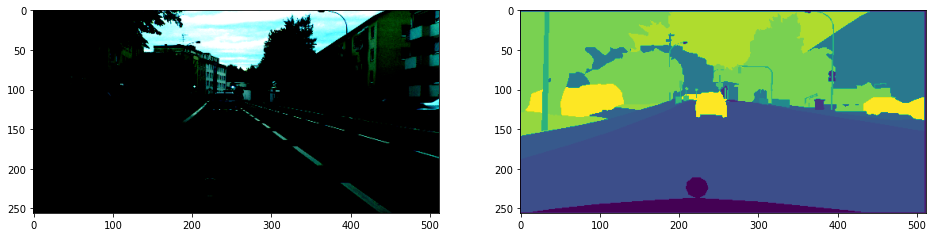

In [ ]:
# Transform the data
class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']

dataset=MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[20]
print(img.shape,seg.shape)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg)

tensor([ 1,  3,  4,  5,  7,  8,  9, 11, 13, 17, 18, 19, 20, 21, 22, 23, 26],
       dtype=torch.uint8)
17
torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 14], dtype=torch.uint8)
12


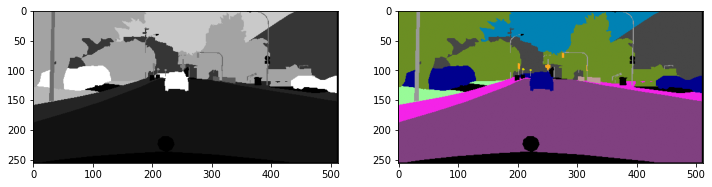

In [ ]:
'''class labels before label correction'''
print(torch.unique(seg))
print(len(torch.unique(seg)))

'''class labels after label correction'''
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

'''Coloring'''
res1=decode_segmap(res.clone())

'''Image plot after coloring'''
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

In [ ]:
class Unet(LightningModule):
  def __init__(self):
    super(Unet,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name="resnet34",        # choosing encoder as resent34
                encoder_weights="imagenet",     # using `imagenet` pre-trained weights for encoder initialization
                in_channels=3,                  # model input channels (3 for RGB)
                classes=n_classes,              # model output channels (number of classes in our dataset - 13)
            )
  
    # initialize parameters
    self.lr=1e-3
    self.batch_size=32
    self.numworker=multiprocessing.cpu_count()//4

    self.criterion= smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.JaccardIndex(task='multiclass', num_classes=n_classes)
    
    self.train_class = MyClass('/content/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
    self.val_class = MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
    
    
  def process(self,image,segment):
    out=self(image)
    segment=encode_segmap(segment)
    loss=self.criterion(out,segment.long())
    iou=self.metrics(out,segment)
    return loss,iou
    
  def forward(self,x):
    return self.layer(x)

  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,num_workers=self.numworker,pin_memory=True)

  def training_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
    self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size, 
                      shuffle=False,num_workers=self.numworker,pin_memory=True)
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [ ]:
# Call and train the model
model = Unet()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
                                        filename='file',save_last=True)

trainer = Trainer(max_epochs=2, auto_lr_find=False, auto_scale_batch_size=False,
                  gpus=-1,precision=16,
                  callbacks=[checkpoint_callback],
                 )
trainer.fit(model)
torch.save(model.state_dict(), drive_root+'unet_model.pth')

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | layer     | Unet                   | 24.4 M
1 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


#### Evaluate U-Net

torch.Size([12, 3, 256, 512]) torch.Size([12, 256, 512]) torch.Size([12, 20, 256, 512])


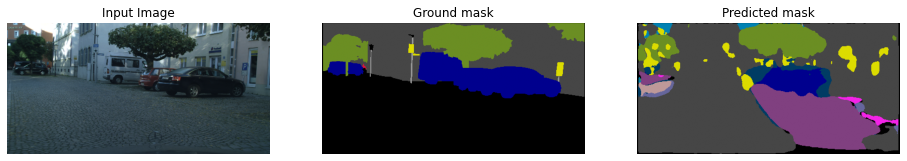

In [ ]:
# load U-net model
model.load_state_dict(torch.load(drive_root+'/unet_model.pth'))

# read the test data
test_class = MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=12, 
                      shuffle=False)

# start model evaluation
model=model.cuda()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        break
print(img.shape,seg.shape,output.shape) 

from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

sample=6
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')